## Part 1: loading in the dataset, and initial EDA

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from itertools import product
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Ensure TensorFlow operates deterministically
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

dow_jones_df = pd.read_csv("dow_jones_data_clean.csv")

# Display the first few rows and column names of the dataset
dow_jones_df.head(), dow_jones_df.columns

2024-12-02 13:24:18.523728: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


(                        Date  Adj Close     Close      High       Low  \
 0  1980-12-12 00:00:00+00:00   0.098943  0.128348  0.128906  0.128348   
 1  1980-12-15 00:00:00+00:00   0.093781  0.121652  0.122210  0.121652   
 2  1980-12-16 00:00:00+00:00   0.086898  0.112723  0.113281  0.112723   
 3  1980-12-17 00:00:00+00:00   0.089049  0.115513  0.116071  0.115513   
 4  1980-12-18 00:00:00+00:00   0.091630  0.118862  0.119420  0.118862   
 
        Open     Volume Ticker  
 0  0.128348  469033600   AAPL  
 1  0.122210  175884800   AAPL  
 2  0.113281  105728000   AAPL  
 3  0.115513   86441600   AAPL  
 4  0.118862   73449600   AAPL  ,
 Index(['Date', 'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume',
        'Ticker'],
       dtype='object'))

In [2]:
dow_jones_df.info()
dow_jones_df.describe(include='all')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361538 entries, 0 to 361537
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Date       361538 non-null  object 
 1   Adj Close  361538 non-null  float64
 2   Close      361538 non-null  float64
 3   High       361538 non-null  float64
 4   Low        361538 non-null  float64
 5   Open       361538 non-null  float64
 6   Volume     361538 non-null  int64  
 7   Ticker     361538 non-null  object 
dtypes: float64(5), int64(1), object(2)
memory usage: 22.1+ MB


,Date,Adj Close,Close,High,Low,Open,Volume,Ticker
count,361538,361538.000000,361538.000000,361538.000000,361538.000000,361538.000000,3.615380e+05,361538
unique,15821,NaN,NaN,NaN,NaN,NaN,NaN,28
top,2012-04-20 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,KO
freq,28,NaN,NaN,NaN,NaN,NaN,NaN,15821
mean,NaN,34.735950,44.823122,45.261430,44.365490,44.636039,2.053661e+07,NaN
std,NaN,59.699655,64.121151,64.724787,63.490108,64.223467,8.102556e+07,NaN
min,NaN,0.002845,0.005208,0.005208,0.004801,0.000000,0.000000e+00,NaN
25%,NaN,1.324075,4.270833,4.312500,4.226386,3.733622,2.124347e+06,NaN
50%,NaN,11.948401,21.945000,22.187500,21.690001,21.920000,5.294992e+06,NaN
75%,NaN,40.156898,55.970001,56.500000,55.408287,55.972920,1.253280e+07,NaN


In [3]:
# Check for missing values
missing_values = dow_jones_df.isnull().sum()
missing_values

Date         0
Adj Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
Ticker       0
dtype: int64

In [4]:
# Convert 'Date' column to datetime format
dow_jones_df['Date'] = pd.to_datetime(dow_jones_df['Date'])

# Set 'Date' as the index
dow_jones_df.set_index('Date', inplace=True)

# Display the updated DataFrame
dow_jones_df.head()

,Adj Close,Close,High,Low,Open,Volume,Ticker
Date,,,,,,,
1980-12-12 00:00:00+00:00,0.098943,0.128348,0.128906,0.128348,0.128348,469033600,AAPL
1980-12-15 00:00:00+00:00,0.093781,0.121652,0.122210,0.121652,0.122210,175884800,AAPL
1980-12-16 00:00:00+00:00,0.086898,0.112723,0.113281,0.112723,0.113281,105728000,AAPL
1980-12-17 00:00:00+00:00,0.089049,0.115513,0.116071,0.115513,0.115513,86441600,AAPL
1980-12-18 00:00:00+00:00,0.091630,0.118862,0.119420,0.118862,0.118862,73449600,AAPL


### Overall stock data graphing

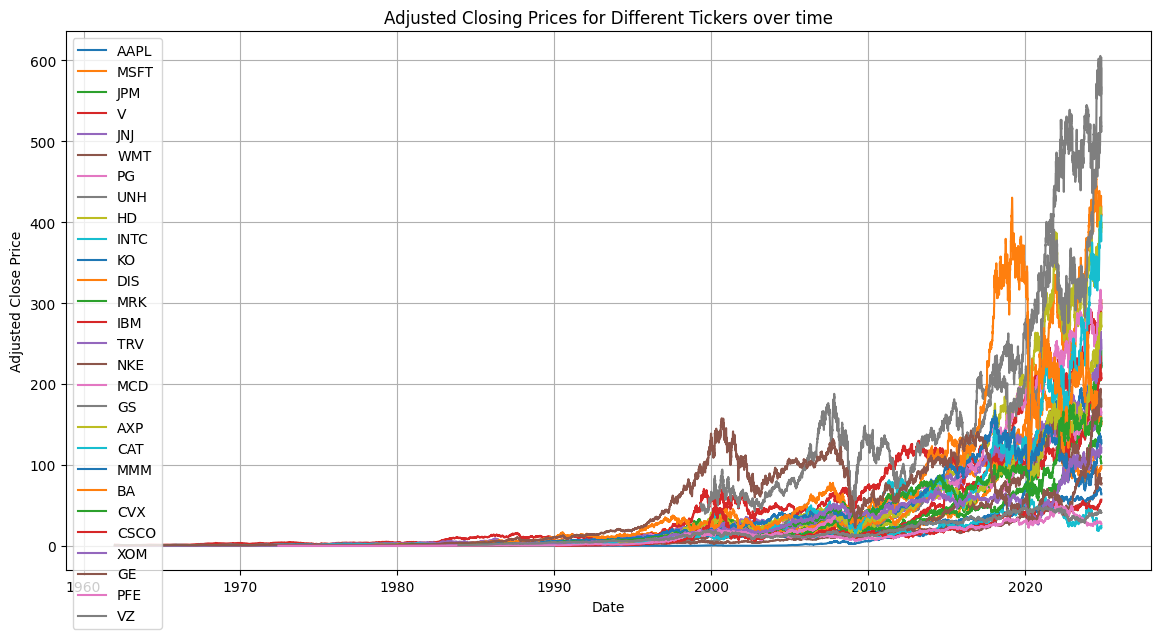

In [5]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['Adj Close'], label=ticker)

plt.title('Adjusted Closing Prices for Different Tickers over time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

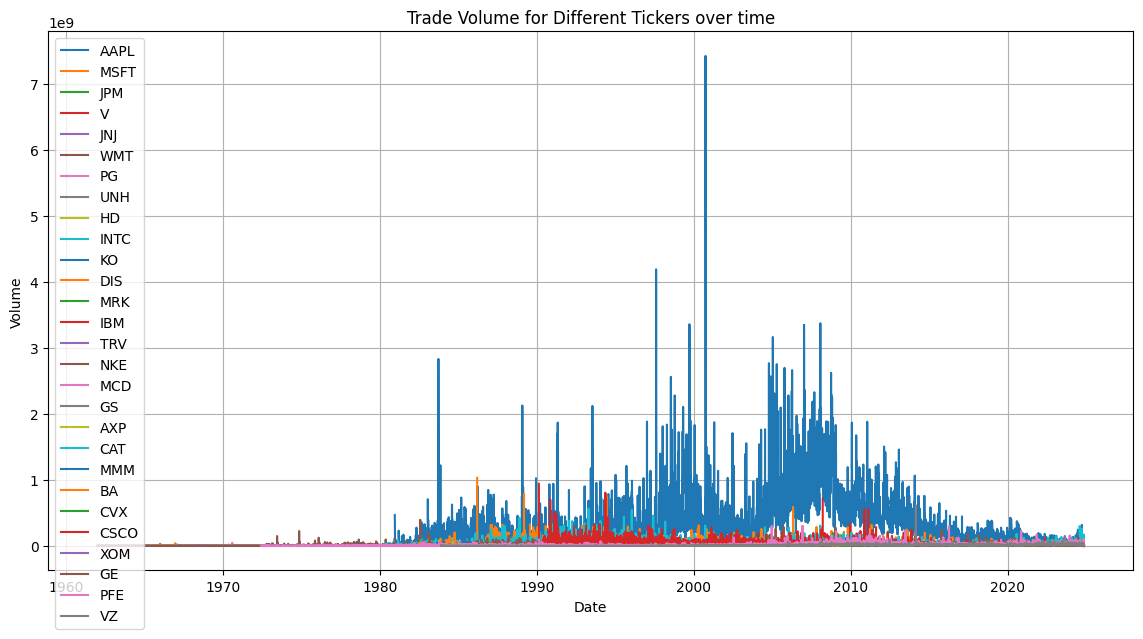

In [6]:
plt.figure(figsize=(14, 7))
for ticker in dow_jones_df['Ticker'].unique():
    ticker_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    plt.plot(ticker_data.index, ticker_data['Volume'], label=ticker)

plt.title('Trade Volume for Different Tickers over time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)
plt.show()

## AAPL data graphing

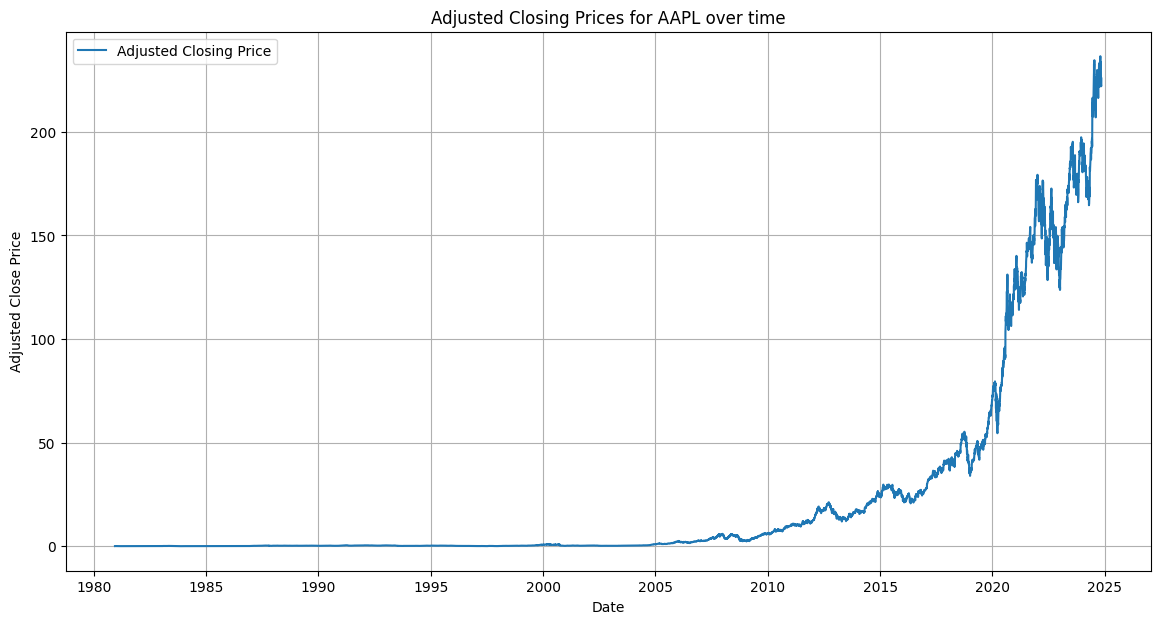

In [7]:
AAPL_data =  dow_jones_df[dow_jones_df['Ticker'] == "AAPL"]
plt.figure(figsize=(14, 7))
plt.plot(AAPL_data.index, AAPL_data['Adj Close'], label= 'Adjusted Closing Price')
plt.title('Adjusted Closing Prices for AAPL over time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

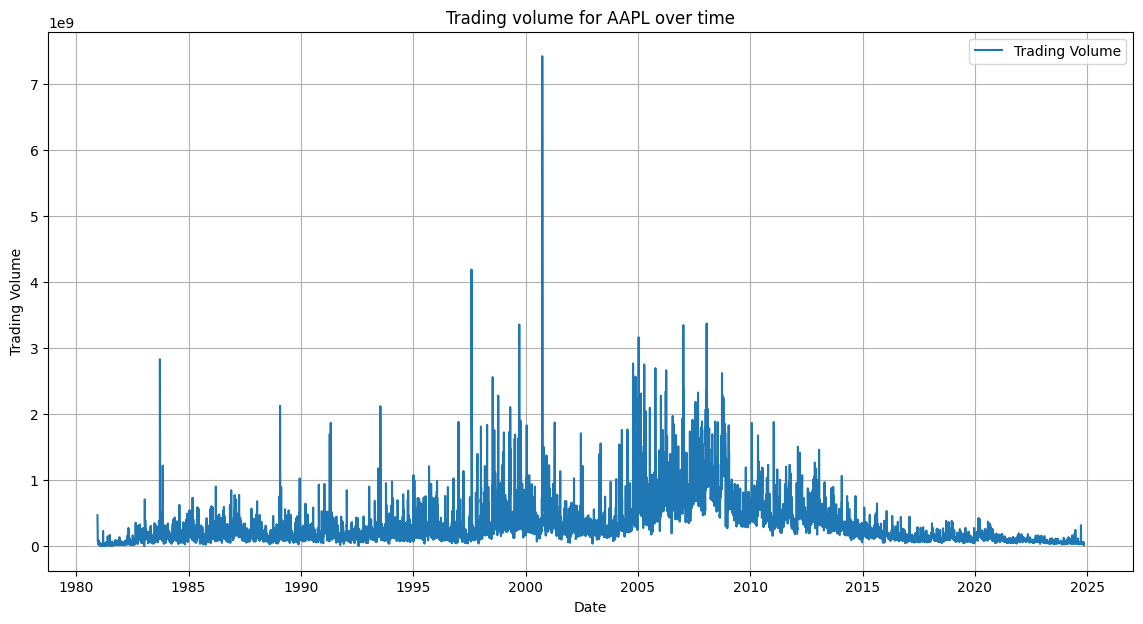

In [8]:
plt.figure(figsize=(14, 7))
plt.plot(AAPL_data.index, AAPL_data['Volume'], label= 'Trading Volume')
plt.title('Trading volume for AAPL over time')
plt.xlabel('Date')
plt.ylabel('Trading Volume')
plt.legend()
plt.grid(True)
plt.show()

### Exploring seasonal decompose for AAPL data

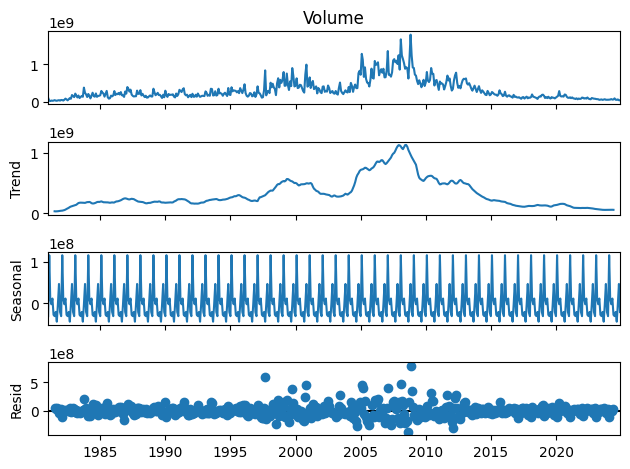

<Figure size 1000x600 with 0 Axes>

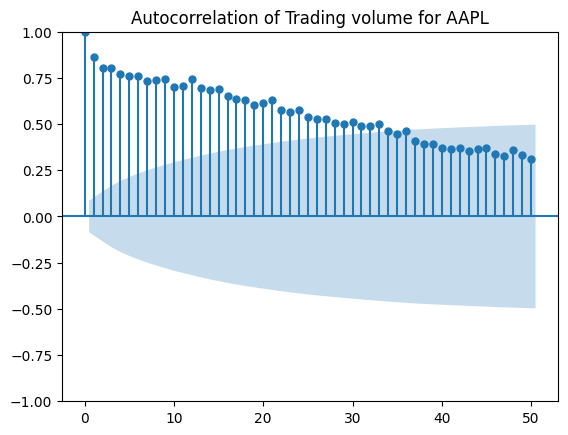

In [9]:
# Decompose the time series (monthly data)
AAPLmonthly_data = AAPL_data['Volume'].resample('M').mean()
decomposition = seasonal_decompose(AAPLmonthly_data, model='additive', period=12)

# Plot the decomposition
decomposition.plot()
plt.show()

# Plot the ACF to check for seasonality
plt.figure(figsize=(10, 6))
plot_acf(AAPLmonthly_data, lags=50, title='Autocorrelation of Trading volume for AAPL')
plt.show()


## part 2: Modeling and hyperparameter tuning 

In [10]:
stock_data = AAPL_data['Volume']
split_index = int(len(stock_data) * 0.8)
train_data = stock_data[:split_index]
test_data = stock_data[split_index:]

### ARIMA model hyperparameter tuning and fitting for AAPL

In [11]:
import itertools

# Define parameter ranges
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

# Generate all combinations of (p, d, q)
pdq_combinations = list(itertools.product(p, d, q))

# Track the best model
best_aic = float('inf')
best_order = None
best_model = None

# Grid search through all combinations
for order in pdq_combinations:
    try:
        model = ARIMA(train_data, order=order)
        fitted_model = model.fit()
        if fitted_model.aic < best_aic:
            best_aic = fitted_model.aic
            best_order = order
            best_model = fitted_model
    except Exception:
        continue

# Display the best parameters and AIC score
best_order, best_aic

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

((1, 1, 2), 364568.5100050126)

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


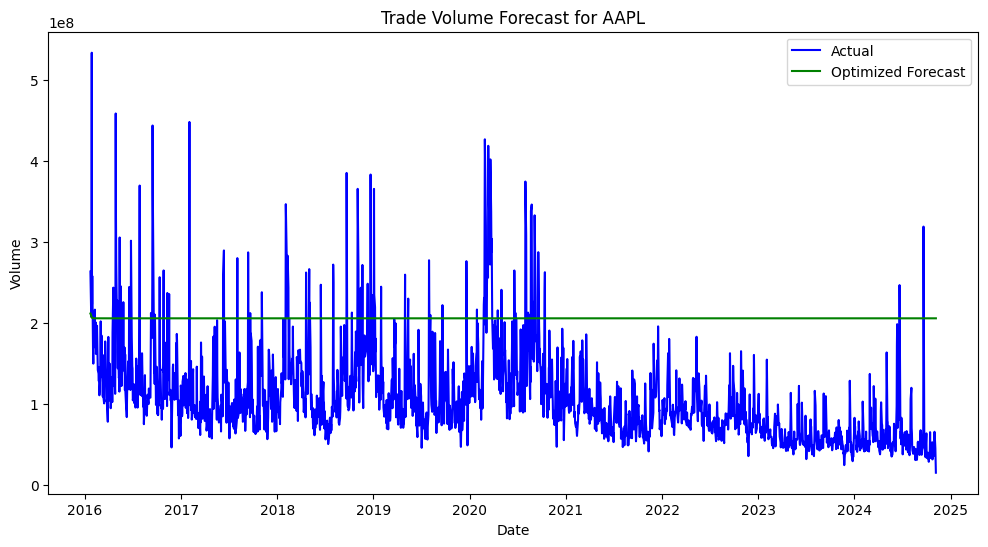

In [12]:
optimized_model = ARIMA(train_data, order=best_order)
fitted_optimized_model = optimized_model.fit()
optimized_forecast = fitted_optimized_model.forecast(steps=len(test_data))

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label="Actual", color="blue")
plt.plot(test_data.index, optimized_forecast, label="Optimized Forecast", color="green")
plt.title('Trade Volume Forecast for AAPL')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
optimized_mae = mean_absolute_error(test_data, optimized_forecast)
optimized_rmse = np.sqrt(mean_squared_error(test_data, optimized_forecast))
optimized_mae, optimized_rmse

(105795368.24900725, 113621490.2405074)

### Code to run ARIMA models and forecasts for each stock
arima_results = {}

for ticker in dow_jones_df['Ticker'].unique():
    stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]
    stock_data = stock_data['Volume']  # Extract the 'Volume' column

    # Train-test split (80-20)
    train_size = int(len(stock_data) * 0.8)
    train, test = stock_data[:train_size], stock_data[train_size:]

    # Fit an ARIMA model (order can be adjusted)
    model = ARIMA(train, order=(2, 0, 2))  # Example ARIMA(5,1,0) order
    model_fit = model.fit()

    # Forecast on test data
    forecast = model_fit.forecast(steps=len(test))

    # Store results
    arima_results[ticker] = {
        'model': model_fit,
        'forecast': forecast,
        'test': test
    }

    # Plot actual vs forecast
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test, label='Actual')
    plt.plot(test.index, forecast, label='Forecast', linestyle='--')
    plt.title(f'Trade Volume Forecast for {ticker}')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

ticker_example = list(arima_results.keys())[0]
print(f"ARIMA Summary for {ticker_example}:")
print(arima_results[ticker_example]['model'].summary())

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - loss: 9.9581e-04 - val_loss: 7.2998e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 6.9293e-04 - val_loss: 6.7184e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 6.5119e-04 - val_loss: 6.2146e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.1993e-04 - val_loss: 6.6472e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 6.1181e-04 - val_loss: 6.0326e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 5.9100e-04 - val_loss: 6.5112e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.0549e-04 - val_loss: 7.0837e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 6.0828e-04 - val_loss: 6.8031e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 5.9521e-04 - val_loss: 6.6199e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 5.8913e-04 - val_loss: 6.7947e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - loss: 9.5160e-04 - val_loss: 9.3338e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 7.2985e-04 - val_loss: 8.8213e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 6.8295e-04 - val_loss: 8.3256e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 6.6569e-04 - val_loss: 8.8102e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 6.4838e-04 - val_loss: 8.3652e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 6.4097e-04 - val_loss: 8.1670e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 6.3570e-04 - val_loss: 8.0456e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.4802e-04 - val_loss: 8.3466e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.3855e-04 - val_loss: 8.1519e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.3827e-04 - val_loss: 7.9525e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 1/10

/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.0010 - val_loss: 6.4083e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 8.3403e-04 - val_loss: 5.7723e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 7.7177e-04 - val_loss: 5.4510e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 7.4301e-04 - val_loss: 5.1949e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 7.1871e-04 - val_loss: 5.0220e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 7.1461e-04 - val_loss: 4.9534e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 7.0473e-04 - val_loss: 4.8907e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 6.9553e-04 - val_loss: 5.0521e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 7.0635e-04 - val_loss: 4.9087e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.9465e-04 - val_loss: 4.8611e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.0013 - val_loss: 6.3695e-04
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 8.4233e-04 - val_loss: 6.2378e-04
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 8.0045e-04 - val_loss: 5.8743e-04
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 7.4909e-04 - val_loss: 5.8586e-04
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 7.3036e-04 - val_loss: 5.7684e-04
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 7.1868e-04 - val_loss: 5.9782e-04
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 7.1711e-04 - val_loss: 6.0241e-04
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 39ms/step - loss: 6.9687e-04 - val_loss: 6.2257e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 7.0927e-04 - val_loss: 6.0278e-04
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.9471e-04 - val_loss: 6.0790e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


276/276 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - loss: 9.7284e-04 - val_loss: 0.0012
Epoch 2/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 7.3680e-04 - val_loss: 0.0011
Epoch 3/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - loss: 6.8845e-04 - val_loss: 0.0011
Epoch 4/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.7207e-04 - val_loss: 0.0010
Epoch 5/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 6.5564e-04 - val_loss: 0.0010
Epoch 6/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.5501e-04 - val_loss: 0.0010
Epoch 7/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 6.4944e-04 - val_loss: 0.0010
Epoch 8/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 6.3483e-04 - val_loss: 9.9192e-04
Epoch 9/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 6.3497e-04 - val_loss: 0.0010
Epoch 10/10
276/276 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - loss: 6.3058e-04 - val_loss: 9.9240e-04
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


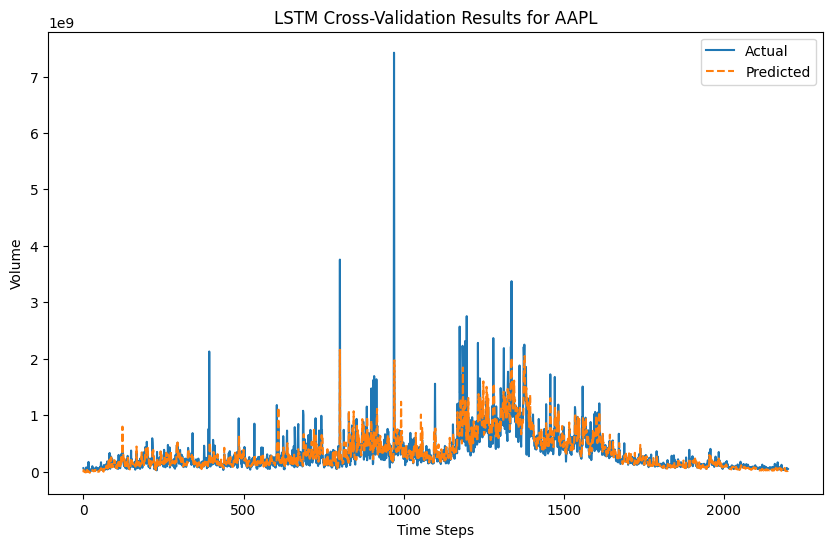

Cross-Validation Results for AAPL:
Fold MSE: [3.3228078247876384e+16, 4.380291992471973e+16, 2.6775504294968588e+16, 3.177259203931127e+16, 5.463556120047841e+16]
Average MSE: 38042931141470872.0000


In [15]:
AAPL_volume = stock_data.values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
AAPL_volume_scaled = scaler.fit_transform(AAPL_volume)

def create_sequences(data, time_steps=60):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i - time_steps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

time_steps = 60
X, y = create_sequences(AAPL_volume_scaled, time_steps)

# Reshape input for LSTM
X = X.reshape((X.shape[0], X.shape[1], 1))

# Perform K-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
fold_mse = []
predictions_all_folds = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Build the LSTM model with Dropout to prevent overfitting
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # EarlyStopping to avoid overfitting
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Train the model
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop])

    # Make predictions on the test fold
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate and store MSE for this fold
    mse = mean_squared_error(y_test_actual, predictions)
    fold_mse.append(mse)

    # Store predictions for visualization
    predictions_all_folds.append((y_test_actual, predictions))

# Store overall results for this stock
cv_results = {}
cv_results["AAPL"] = {
    'mse': fold_mse,
    'avg_mse': np.mean(fold_mse),
    'predictions': predictions_all_folds
}

# Plot actual vs predicted for the last fold
plt.figure(figsize=(10, 6))
plt.plot(predictions_all_folds[-1][0], label='Actual')
plt.plot(predictions_all_folds[-1][1], label='Predicted', linestyle='--')
plt.title('LSTM Cross-Validation Results for AAPL')
plt.xlabel('Time Steps')
plt.ylabel('Volume')
plt.legend()
plt.show()

print("Cross-Validation Results for AAPL:")
print(f"Fold MSE: {fold_mse}")
print(f"Average MSE: {np.mean(fold_mse):.4f}")

# Cross-validation results storage
cv_results = {}

# Loop through each stock ticker in the dataset
for ticker in dow_jones_df['Ticker'].unique():
    stock_data = dow_jones_df[dow_jones_df['Ticker'] == ticker]['Volume'].values.reshape(-1, 1)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    stock_data_scaled = scaler.fit_transform(stock_data)

    # Create sequences of 60 time steps
    def create_sequences(data, time_steps=60):
        X, y = [], []
        for i in range(time_steps, len(data)):
            X.append(data[i - time_steps:i, 0])
            y.append(data[i, 0])
        return np.array(X), np.array(y)

    time_steps = 60
    X, y = create_sequences(stock_data_scaled, time_steps)

    # Reshape input for LSTM
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Perform K-Fold Cross Validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_mse = []
    predictions_all_folds = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Build the LSTM model with Dropout to prevent overfitting
        model = Sequential([
            LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
            Dropout(0.2),
            LSTM(50, return_sequences=False),
            Dropout(0.2),
            Dense(25),
            Dense(1)
        ])

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')

        # EarlyStopping to avoid overfitting
        early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        # Train the model
        model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(X_test, y_test), callbacks=[early_stop])

        # Make predictions on the test fold
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

        # Calculate and store MSE for this fold
        mse = mean_squared_error(y_test_actual, predictions)
        fold_mse.append(mse)

        # Store predictions for visualization
        predictions_all_folds.append((y_test_actual, predictions))

    # Store overall results for this stock
    cv_results[ticker] = {
        'mse': fold_mse,
        'avg_mse': np.mean(fold_mse),
        'predictions': predictions_all_folds
    }

    # Plot actual vs predicted for the last fold
    plt.figure(figsize=(10, 6))
    plt.plot(predictions_all_folds[-1][0], label='Actual')
    plt.plot(predictions_all_folds[-1][1], label='Predicted', linestyle='--')
    plt.title(f'LSTM Cross-Validation Results for {ticker}')
    plt.xlabel('Time Steps')
    plt.ylabel('Volume')
    plt.legend()
    plt.show()

    print(f"Cross-Validation Results for {ticker}:")
    print(f"Fold MSE: {fold_mse}")
    print(f"Average MSE: {np.mean(fold_mse):.4f}")

# Example: Access cross-validation results for a specific stock
ticker_example = list(cv_results.keys())[0]
print(f"Results for {ticker_example}:")
print(f"Average MSE: {cv_results[ticker_example]['avg_mse']:.4f}")
